In [ ]:
#can be skipped they've been installed
!pip install mlfinlab
!pip install yahooquery

In [ ]:
# importing all dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from yahooquery import Ticker
import datetime as dt
import mlfinlab
from mlfinlab.portfolio_optimization import HierarchicalRiskParity,HierarchicalEqualRiskContribution
from mlfinlab.portfolio_optimization import RiskMetrics
from mlfinlab.portfolio_optimization import RiskEstimators,ReturnsEstimators
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from yahooquery import Ticker
import datetime as dt
from sklearn.decomposition import PCA

In [ ]:
#define function to load our data
def get_data(ticker_list, interval = '1wk', start = dt.date.today() - dt.timedelta(days=1825), 
             end = dt.date.today()):
    '''Get the necessary data from Yahoo Finance using Yahooquery API
       Input a list of ticker codes and number of years
       Return the asset historical Adj close price

       Interval options = 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo

       Additional arguments you can provide to the method are start and end. 
       Start and end dates can be either strings with a date format of yyyy-mm-dd or as a datetime.datetime object'''

    return pd.DataFrame(Ticker(ticker_list).history(
        interval = interval, start = start, end = end)['adjclose']).unstack().T.reset_index(level=0, drop=True)

def get_returns(historical_price):
    '''Get the stock returns over a certain period
       Input a Panda data frame of stock price and frequency
       return returns of assets'''
    
    price = historical_price/historical_price.shift(1) - 1
    return price.iloc[1:]

In [ ]:
#Create function to backtest our HRP and HERC models
def hr_backtest(returns, estimation_window, steps, herc = False, smoothing = 1):
    '''
    steps: how often the portfolio should be rebalanced
    estimation windows: previous n_period to estimate risk and weight
    weighting: the weighting method
    r: input returns
    '''
    n_periods = returns.shape[0]   
    windows = [(start, start+estimation_window) for start in range(0, n_periods-estimation_window,steps)]
    weight = []

    if herc == False:
      weighting = HierarchicalRiskParity()
      
      for win in windows:
        cov = RiskEstimators.shrinked_covariance(returns.iloc[win[0]:win[1]], shrinkage_type='oas')+1e-10

        weighting.allocate(asset_names=returns.columns,
                            asset_returns=returns.iloc[win[0]:win[1]], 
                            covariance_matrix = cov,
                            linkage='ward')
            
        weight.append(weighting.weights.values)
    
    if herc == True:
      weighting = HierarchicalEqualRiskContribution()

      for win in windows:
        cov = RiskEstimators.shrinked_covariance(returns.iloc[win[0]:win[1]], shrinkage_type='oas')+1e-10

        weighting.allocate(asset_names=returns.columns,
                            asset_returns=returns.iloc[win[0]:win[1],:],
                            covariance_matrix = cov,
                            risk_measure = 'equal_weighting',              
                            linkage='ward')
        
        weight.append(weighting.weights.values.tolist())
      
    weight = [i[0] for i in weight]

    weights = pd.DataFrame(weight, index=returns.iloc[estimation_window:][::steps].index,
                          columns=returns.columns).reindex(returns.iloc[estimation_window:].index).fillna(method='ffill')

    p_returns = (weights * returns).sum(axis="columns",  min_count=1)
    return p_returns, pd.DataFrame(weight, index=returns.iloc[estimation_window:][::steps].index, columns=returns.columns)

In [ ]:
#define our functions for vanilla risk pairity
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol 

def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov @ w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return np.absolute(risk_contrib)

def target_risk_contributions(target_risk, cov, n_iter = 1):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    # bounds = ((-1.0, 1.0),) * n
    bounds = ((.0, 1.0),) * n
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},)
    
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Root Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = init_guess
    weights = minimize(msd_risk, weights,
                        args=(target_risk, cov), method='SLSQP',
                        options={'disp': False},
                        constraints=constraints,
                        bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

def weight_rp(r, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = RiskEstimators.shrinked_covariance(r, shrinkage_type='oas')
    est_cov = pd.DataFrame(cov, index=r.columns, columns=r.columns)
    return equal_risk_contributions(est_cov)

def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    return ew

def PCA_Weight(r):
    est_cov = RiskEstimators.shrinked_covariance(r, shrinkage_type='oas')
    ev , eig = np.linalg.eig(est_cov)
    idx = ev.argsort()[::-1]
    ev = ev[idx] # Use indices on eigv vector
    eig = eig[:,idx] # 

    pc1 = eig[:,0]           

    optimal_weights = pc1 / sum(pc1)

    optimal_weights += np.abs(np.min(optimal_weights))
    optimal_weights /= sum(optimal_weights)

    return pd.Series(optimal_weights, index=r.columns)

def backtest(r, estimation_window=30, steps = 10, weighting=weight_ew, verbose=False, **kwargs):
    '''
    steps: how often the portfolio should be rebalanced
    estimation windows: previous n_period to estimate risk and weight
    weighting: the weighting method
    r: input returns
    '''
    n_periods = r.shape[0]   
    windows = [(start, start+estimation_window) for start in range(0, n_periods-estimation_window,steps)]
    weight = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    weights = pd.DataFrame(weight, index=r.iloc[estimation_window:][::steps].index, columns=r.columns).reindex(r.index).fillna(method='ffill')
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns, pd.DataFrame(weight, index=r.iloc[estimation_window:][::steps].index, columns=r.columns)

# Load Data

In [ ]:
#Load stock price data using yahoo query
interval = "1d"
ASX_prices = get_data(['^AXJO'], start = "2016-01-01", end = "2020-06-01", interval = interval).fillna(method='ffill')
ASX_returns = ReturnsEstimators.calculate_returns(ASX_prices).fillna(0)

# ticker_list = ['ORG.AX', 'BEN.AX', 'WOR.AX', 'SYD.AX', 'SUN.AX', 'MQG.AX', 'TAH.AX', 'QBE.AX',
#                'QAN.AX', 'VCX.AX', 'SGP.AX', 'SCG.AX', 'ALL.AX', 'CPU.AX', 'ANZ.AX']

ticker_list = ['ORG.AX', 'BEN.AX', 'WOR.AX', 'SYD.AX', 'OOO.AX', 'SUN.AX', 'MQG.AX', 'TAH.AX', 'QBE.AX', 
               'QAN.AX', 'VCX.AX', 'SGP.AX', 'SCG.AX', 'ALL.AX', 'CPU.AX', 'KMD.AX', 'WEB.AX', 'ANZ.AX', 'ASX.AX', 'BHP.AX','BXB.AX','COH.AX','CBA.AX','CSL.AX','IAG.AX','RIO.AX','RHC.AX','WOW.AX','WES.AX','COL.AX','NCM.AX','IXI.AX']

stock_prices = get_data(ticker_list, start = "2016-01-01", end = "2020-06-01", interval = interval).fillna(method='ffill')
returns = ReturnsEstimators.calculate_returns(stock_prices).fillna(0)

In [ ]:
#Calculate covariance matrix for our HRP and HERC model
cov = RiskEstimators.exponential_covariance(returns, window_span= 180)
cov = pd.DataFrame(cov, index=returns.columns, columns=returns.columns)

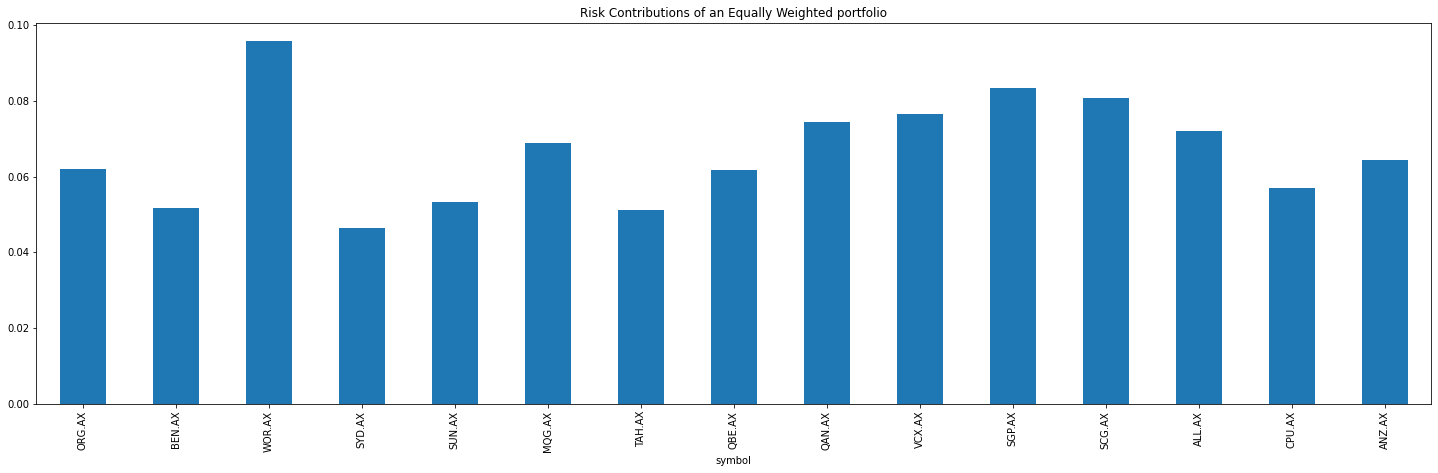

In [ ]:
#check risk contribution of our stocks
risk_contribution(weight_ew(returns), cov)\
.plot.bar(title="Risk Contributions of an Equally Weighted portfolio", figsize=(25,7));

# Vanilla Risk Pairity

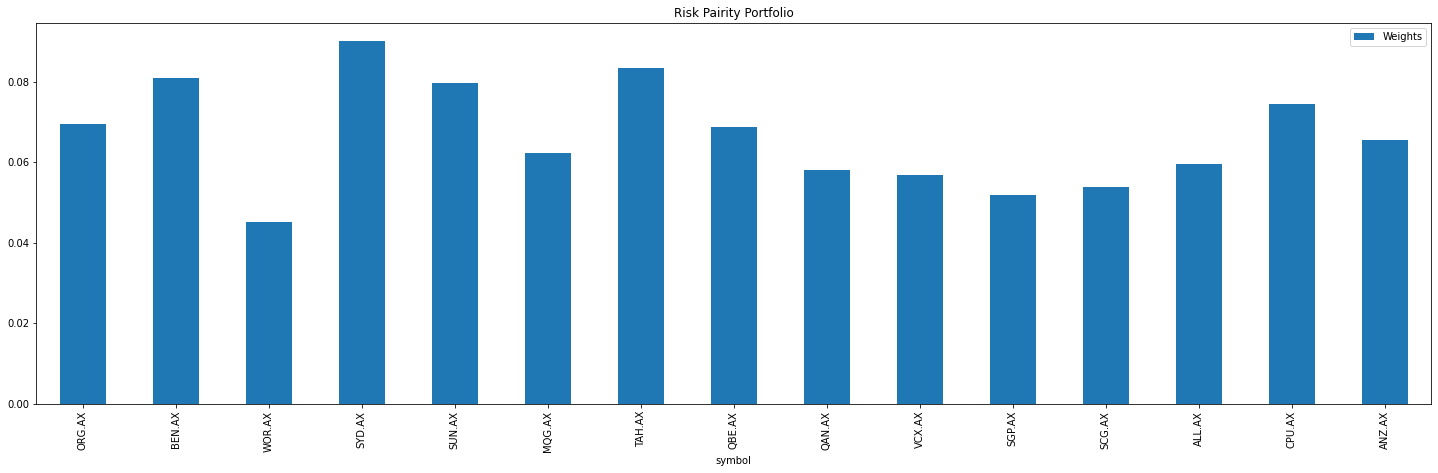

In [ ]:
#Create our Vanilla risk pairity model
RP = pd.DataFrame(weight_rp(returns.iloc[-100:,]))
RP.index = returns.columns
RP.columns = ['Weights']
RP.plot.bar(figsize=(25,7),title='Risk Pairity Portfolio')
plt.show()

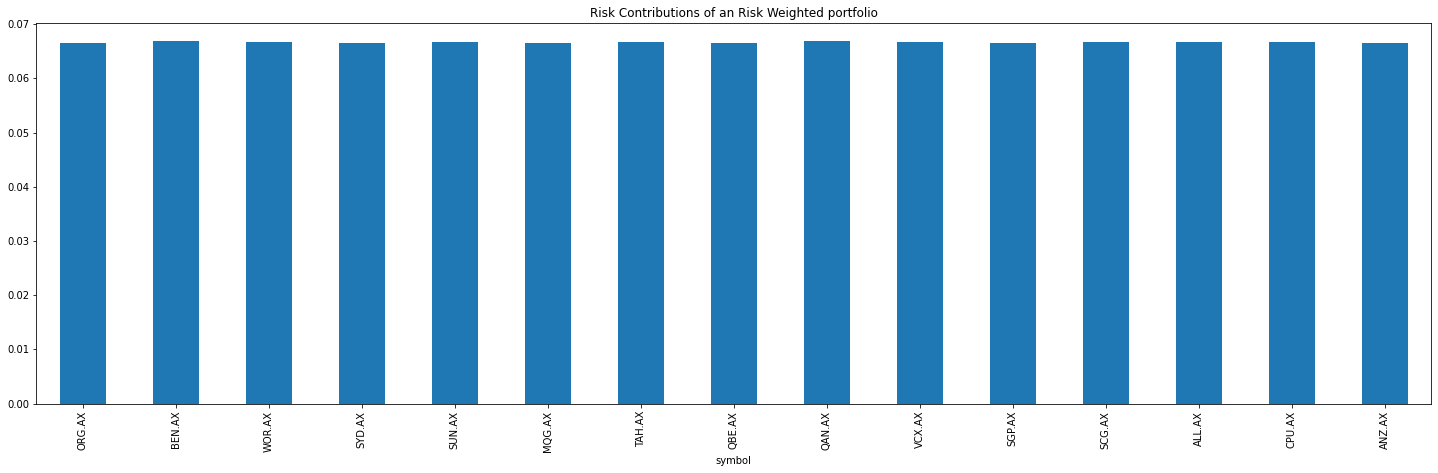

In [ ]:
#visualise risk contribution per stock
risk_contribution(weight_rp(returns.iloc[-100:,]), cov)\
.plot.bar(title="Risk Contributions of an Risk Weighted portfolio", figsize=(25,7));

# Define Covariance For Our HERC and HRP models

In [ ]:
#Calculate covariance matrix for our HRP and HERC model
cov = RiskEstimators.shrinked_covariance(returns.iloc[-20:], shrinkage_type='oas')+1e-10
cov = pd.DataFrame(cov, index=returns.columns, columns=returns.columns)

# Hierarchical Risk Parity

In [ ]:
#Create our HRP protfolio
hrp = HierarchicalRiskParity()
hrp.allocate(asset_names=stock_prices.columns,
             asset_returns=returns.iloc[-20:,:],
             covariance_matrix = cov,
             linkage='ward')

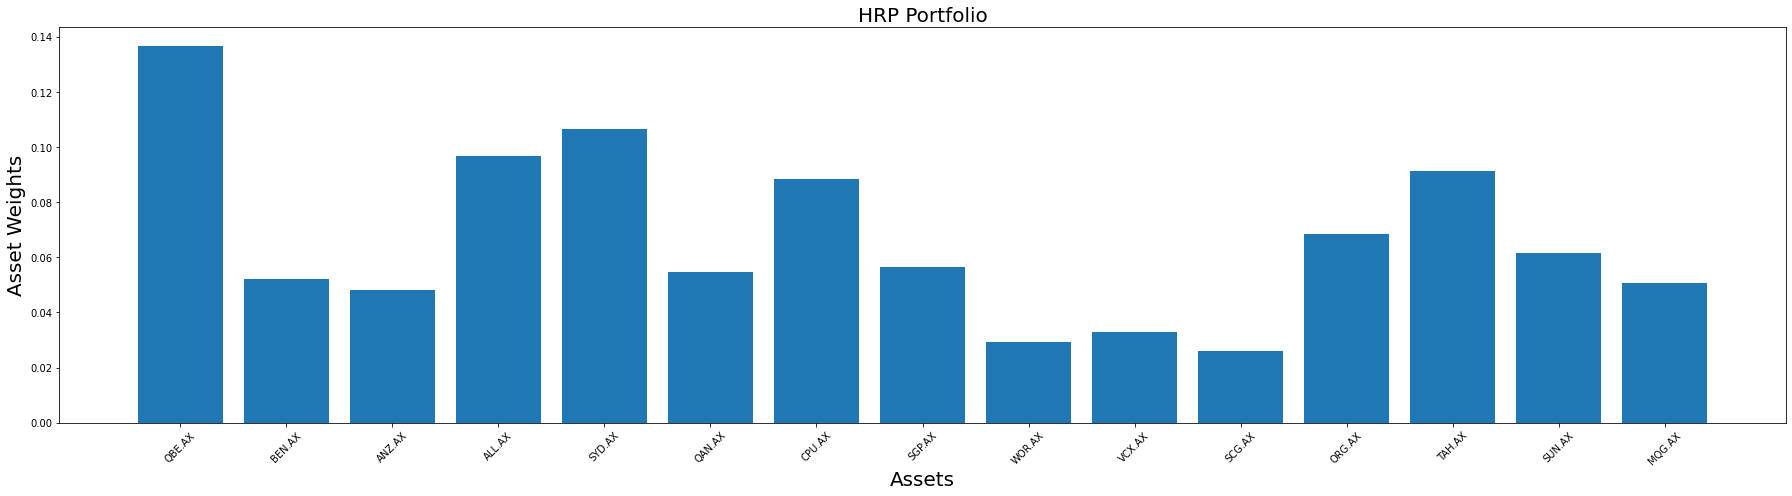

In [ ]:
# plotting our optimal portfolio
hrp_weights = hrp.weights
y_pos = np.arange(len(hrp_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(hrp_weights.columns), hrp_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP Portfolio', size=20)
plt.tight_layout()
plt.savefig('HRP Portfolio Weights')
plt.show()

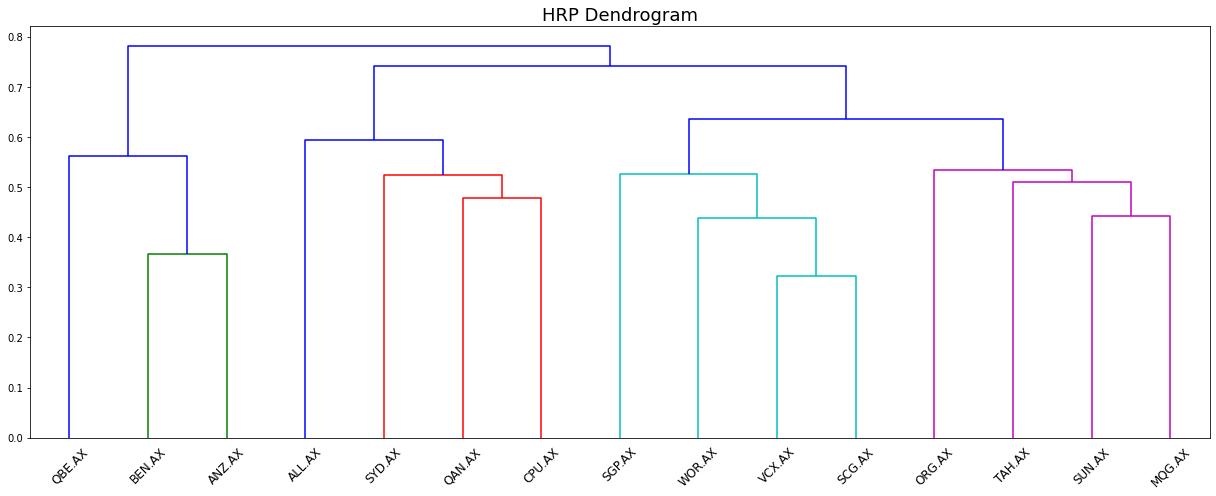

In [ ]:
# plotting dendrogram of HRP portfolio
plt.figure(figsize=(17,7))
hrp.plot_clusters(stock_prices.columns)
plt.title('HRP Dendrogram', size=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

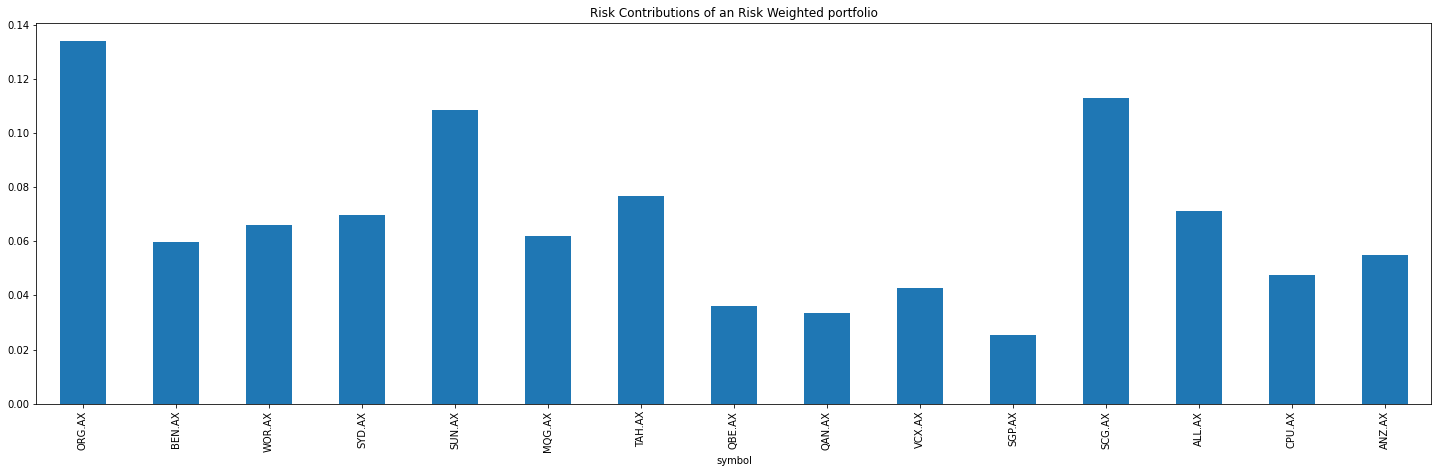

In [ ]:
#visualise risk contribution per stock
risk_contribution(hrp.weights.values[0], cov)\
.plot.bar(title="Risk Contributions of an Risk Weighted portfolio", figsize=(25,7));

# Hierarchical Equal Risk Contribution

In [ ]:
#Create our HERC portfolio
from mlfinlab.portfolio_optimization import HierarchicalEqualRiskContribution
herc = HierarchicalEqualRiskContribution()

herc.allocate(asset_names=stock_prices.columns,
             asset_returns=returns.iloc[-20:,:].fillna(0),
             risk_measure = 'equal_weighting',
             covariance_matrix = cov.values,
             linkage='ward')

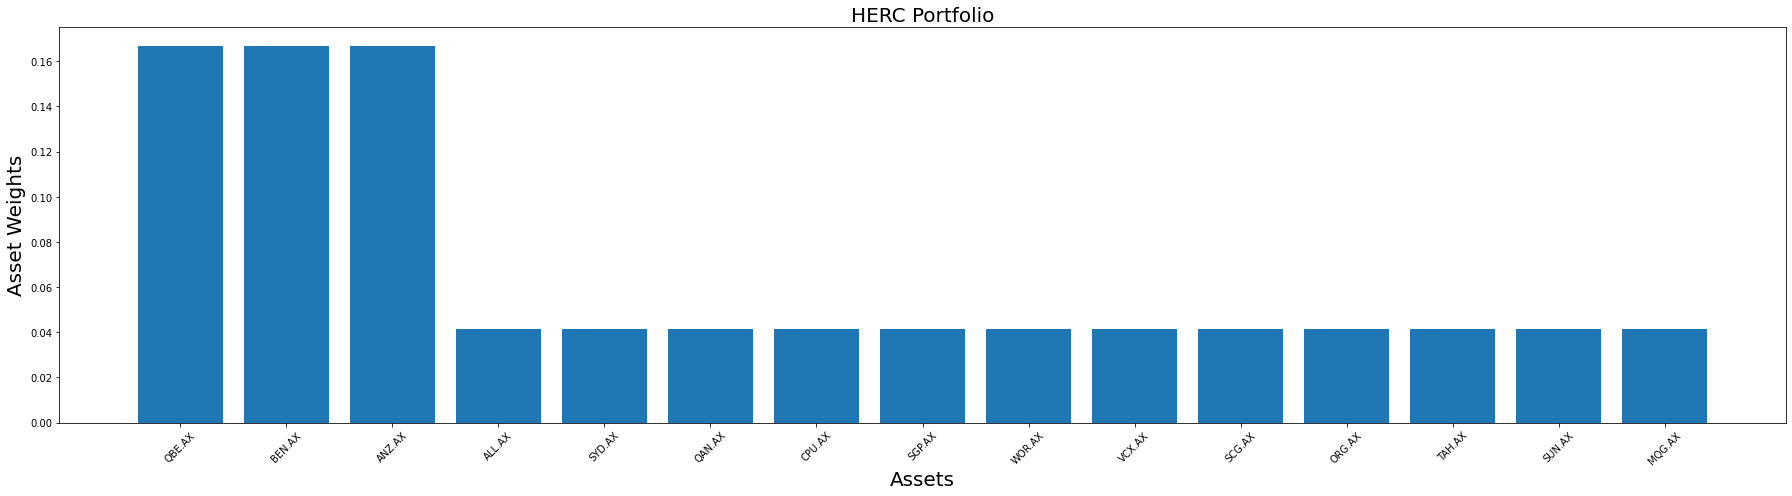

In [ ]:
# plotting our optimal portfolio
herc_weights = herc.weights
y_pos = np.arange(len(herc_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(herc_weights.columns), herc_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HERC Portfolio', size=20)
plt.tight_layout()
plt.savefig('HRP Portfolio Weights')
plt.show()

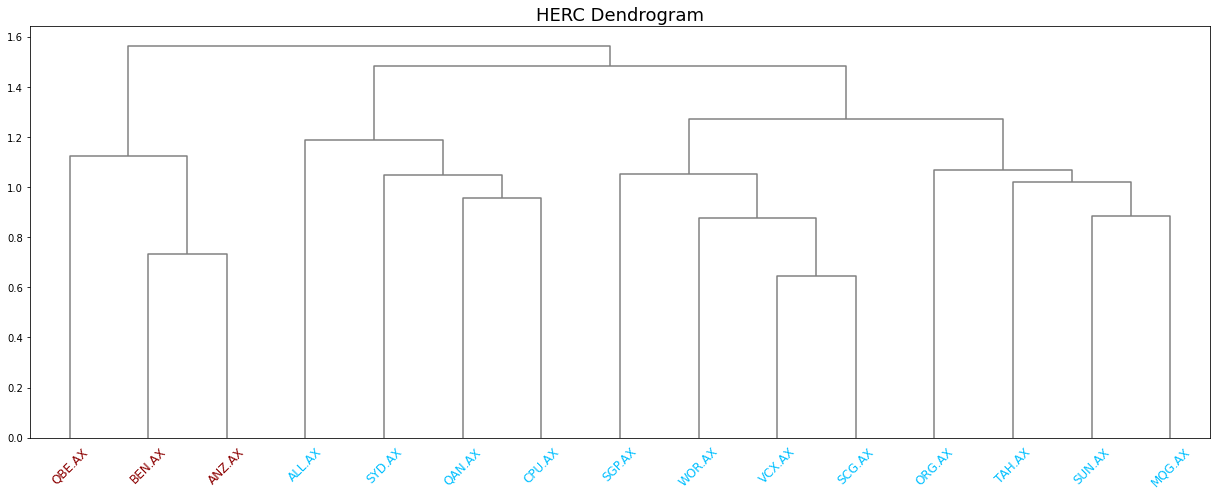

In [ ]:
# plotting dendrogram of HERC portfolio
plt.figure(figsize=(17,7))
herc.plot_clusters(stock_prices.columns)
plt.title('HERC Dendrogram', size=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

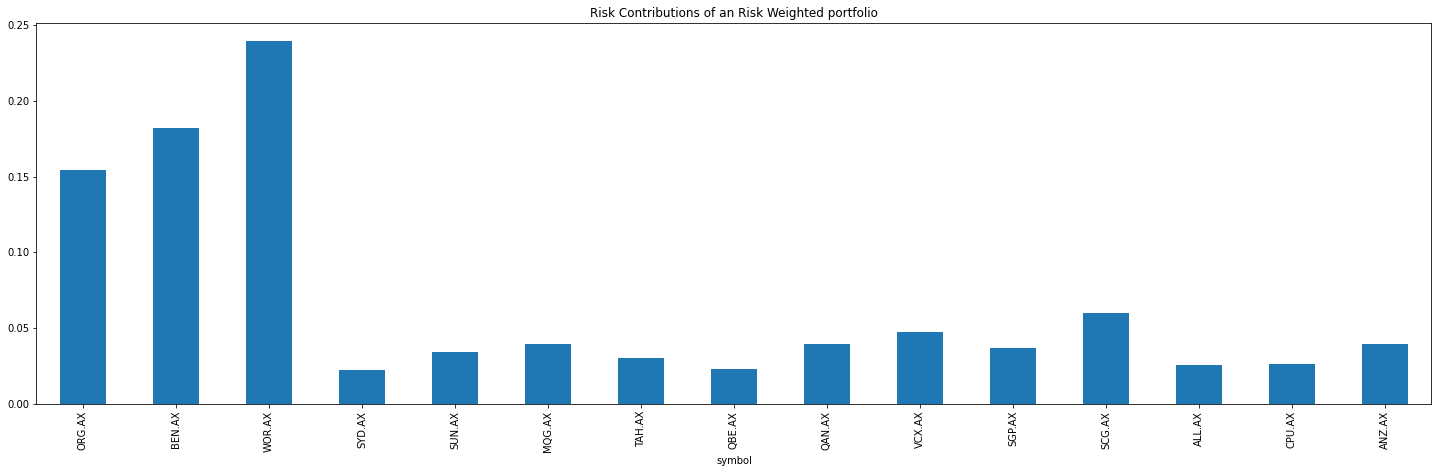

In [ ]:
#visualise risk contribution per stock
risk_contribution(herc.weights.values[0], cov)\
.plot.bar(title="Risk Contributions of an Risk Weighted portfolio", figsize=(25,7));

# Back Test Our Portfolios

In [ ]:
#Backtest our portfolio strategy

#define parameters
window = 60; step = 5
date = "2018-01-01"
ret = returns[date:].fillna(0)

#Based on experiments sforter windows seems to perform better for HERC and HRP
HERC, herc_w = hr_backtest(ret.iloc[100-window:], estimation_window=window, steps = step, herc = True)
HRP, hrp_w = hr_backtest(ret.iloc[100-window:], estimation_window=window, steps = step)
EW, ew_w = backtest(ret.iloc[100-window:], estimation_window=window, steps = step, weighting=weight_ew)
PC, pca_w = backtest(ret.iloc[100-window:], estimation_window=window, steps = step, weighting=PCA_Weight)

#For Vanilla Risk Pairity we found that long estimation window seems to provide more robust result
RP, rp_w = backtest(ret, estimation_window=100, steps = step,weighting=weight_rp)

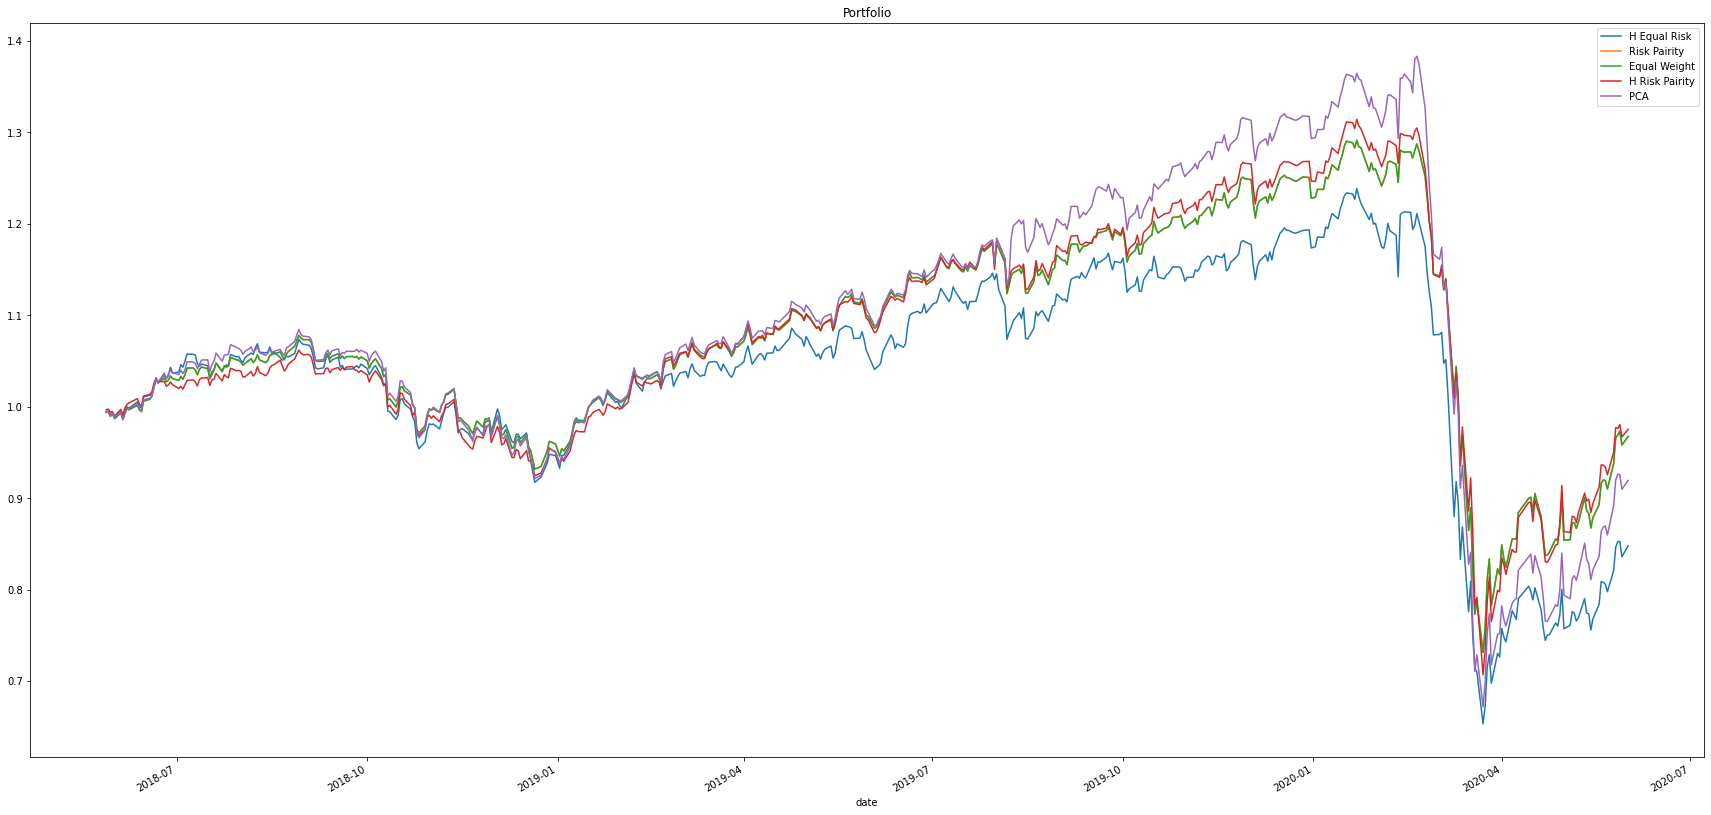

In [ ]:
#Visualise result
starting_value = 1
btr = pd.DataFrame({"H Equal Risk":HERC, "Risk Pairity":RP, "Equal Weight": EW, 'H Risk Pairity':HRP, "PCA":PC})
((1+btr).cumprod()*starting_value).plot(figsize=(30,15), title="Portfolio")

# Visualise Weight Allocation

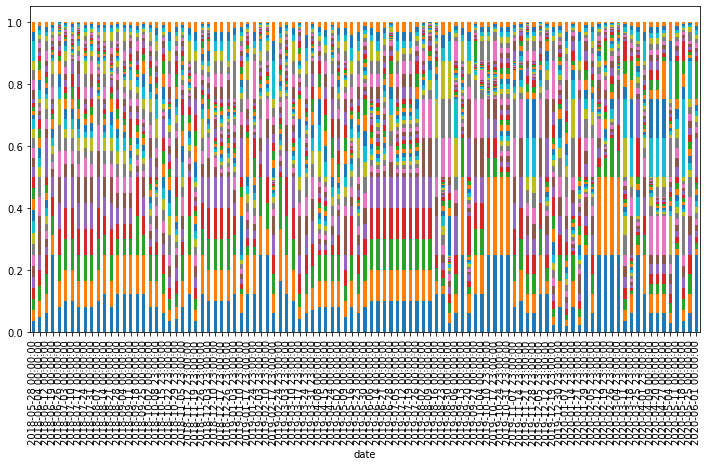

In [ ]:
#Visualise HERC asset allocation
herc_w.plot.bar(stacked = True, figsize=(12,6),legend=None)

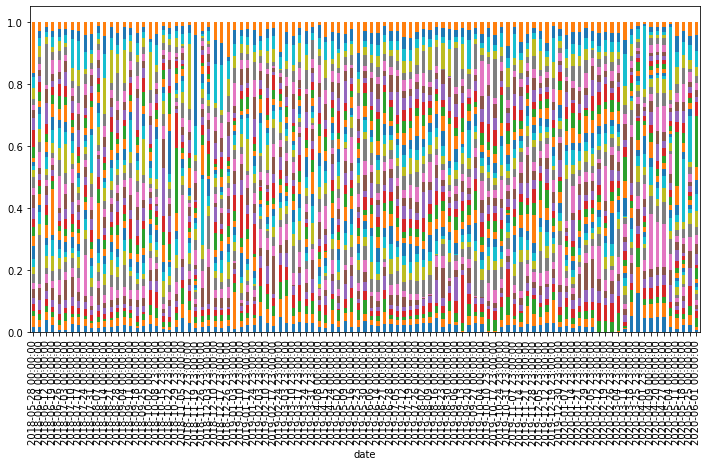

In [ ]:
#Visualise HRP asset allocation
hrp_w.plot.bar(stacked = True, figsize=(12,6),legend=None)

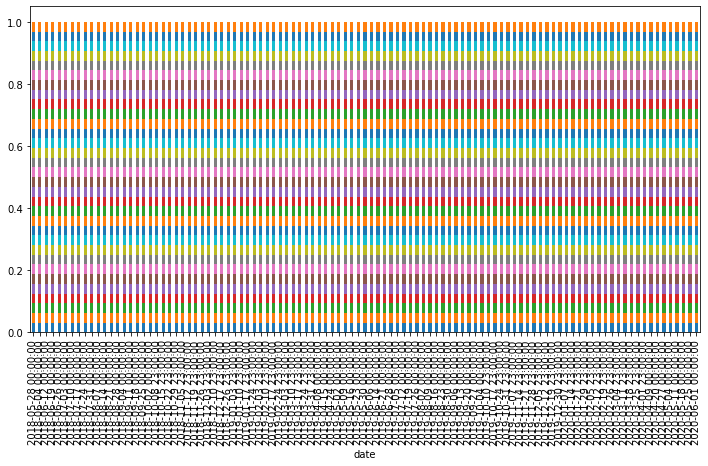

In [ ]:
#Visualise risk pairity asset allocation
rp_w.plot.bar(stacked = True, figsize=(12,6),legend=None)

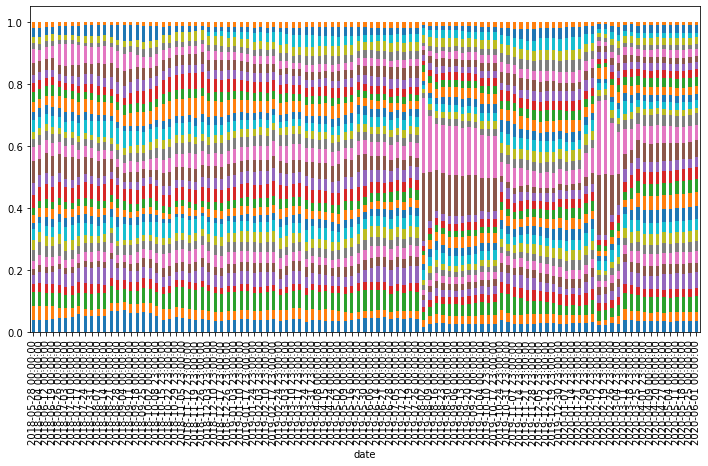

In [ ]:
#Visualise risk pairity asset allocation
pca_w.plot.bar(stacked = True, figsize=(12,6),legend=None)

# Cara dapet weight per stock

In [ ]:
# rp_w['ORG.AX']

# Historical Weight

di uncomment kalau mau di simpan jadi csv cara delete tanda #

In [ ]:
# from google.colab import files
# herc_w.to_csv("herc_w.csv")
# files.download("herc_w.csv")

In [ ]:
# hrp_w.to_csv("hrp_w.csv")
# files.download("hrp_w.csv")

In [ ]:
# rp_w.to_csv("rp_w.csv")
# files.download("rp_w.csv")

# Current Weight

In [ ]:
# RP = pd.DataFrame(weight_rp(returns.iloc[-360:,]))
# RP.index = returns.columns
# RP.columns = ['Weights']
# RP.to_csv("RP.csv")
# files.download("RP.csv")

In [ ]:
# hrp.weights.T.to_csv("HRP.csv")
# files.download("HRP.csv")

In [ ]:
# herc.weights.T.to_csv("HERC.csv")
# files.download("HERC.csv")